# Оценка вакантности по домам

Самая главная тетрадка с ответом на основной вопрос исследования. В трёх предыдущих готовились вспомогательные данные, а тут идут основные расчёты.

## Идея

Берём дом. Мы знаем общее число жителей и число квартир. Мы также знаем, сколько человек в среднем живёт в одной *непустой* квартире. Значит, мы можем посчитать число непустых квартир: делим общее число жителей на среднее число жителей в непустой квартире. Раз так, то мы знаем и число пустых квартир: общее минус число непустых.

## Нюансы

1. Общее число жителей — это на самом деле число зарегистрированных. Оно не обязательно точное. Впрочем, оно хорошо коррелирует с общедомовым потреблением электроэнергии, так что считаем, что всё ОК.
2. Среднее число проживающих в непустой квартире у нас есть только по муниципалитетам — предполагаем, что оно неизменно во всех домах муниципалитета. Это неправда, но как есть.
3. У нас куча пропусков в данных и прочих проблем — тут тоже как есть.

In [27]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

- `flat_sizes` — число квартир с разным количеством комнат по домам из тетрадки №3
- `geo` — координаты домов из тетрадки №1
- `houses` — открытые данные ФРТ по домам (те же, что в тетрадке №1)
- `ppf_by_mo` — среднее число жителей непустых квартир по данным переписи (из тетрадки №2)
- `repair_data` — открытые данные ФРТ по капремонту (те же, что в тетрадке №2)

In [2]:
flat_sizes = pd.read_csv("data/flats_by_n_rooms.csv")
geo = pd.read_csv("data/houses_coords.csv")
houses = pd.read_csv("data/export-reestrmkd-77-20240701.zip", sep=";", decimal=",")
ppf_by_mo = pd.read_csv("data/ppf_by_mo.csv")
repair_data = pd.read_csv("data/export-kr1_1-77-20240701.zip", sep=";", decimal=",")

Дальше просто посмотрим на данные.

In [3]:
flat_sizes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94925 entries, 0 to 94924
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   houseguid  94925 non-null  object 
 1   n_rooms    94925 non-null  int64  
 2   n_flats    94925 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


In [4]:
flat_sizes.head()

,houseguid,n_rooms,n_flats
0,00065add-ac65-4dea-9759-285169ea505f,3,53.316456
1,00065add-ac65-4dea-9759-285169ea505f,4,18.455696
2,00095edb-6cf9-41b4-985c-bf942cf9717e,1,25.714286
3,00095edb-6cf9-41b4-985c-bf942cf9717e,3,34.285714
4,0009f2bb-b015-43c7-a166-51a33911c520,1,55.000000


In [5]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34700 entries, 0 to 34699
Data columns (total 60 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               34700 non-null  int64  
 1   region_id                        34700 non-null  object 
 2   area_id                          1318 non-null   object 
 3   city_id                          2641 non-null   object 
 4   street_id                        33566 non-null  object 
 5   shortname_region                 34700 non-null  object 
 6   formalname_region                34700 non-null  object 
 7   shortname_area                   1318 non-null   object 
 8   formalname_area                  1318 non-null   object 
 9   shortname_city                   2641 non-null   object 
 10  formalname_city                  2641 non-null   object 
 11  shortname_street                 33566 non-null  object 
 12  formalname_street 

In [6]:
houses.sample(2)

,id,region_id,area_id,city_id,street_id,shortname_region,formalname_region,shortname_area,formalname_area,shortname_city,formalname_city,shortname_street,formalname_street,house_number,building,block,letter,address,houseguid,management_organization_id,built_year,exploitation_start_year,project_type,house_type,is_alarm,method_of_forming_overhaul_fund,floor_count_max,floor_count_min,entrance_count,elevators_count,energy_efficiency,quarters_count,living_quarters_count,unliving_quarters_count,area_total,area_residential,area_non_residential,area_common_property,area_land,parking_square,playground,sportsground,other_beautification,foundation_type,floor_type,wall_material,basement_area,chute_type,chute_count,electrical_type,electrical_entries_count,heating_type,hot_water_type,cold_water_type,sewerage_type,sewerage_cesspools_volume,gas_type,ventilation_type,firefighting_type,drainage_type
879,7693685,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,7c454f20-1a24-479c-bc9b-bab7cbaa9a17,г,Москва,NaN,NaN,NaN,NaN,ул,Академика Пилюгина,14,NaN,4,NaN,"г. Москва, ул. Академика Пилюгина, д. 14, к. 4",d07b875f-ae5a-40ac-ae5a-4b492d06de86,8916818.0,1986.0,1986.0,КОПЭ,Многоквартирный дом,Нет,На счете регионального оператора,22.0,22.0,3.0,9.0,Не присвоен,263,261.0,2.0,21804.4,16146.0,145.0,5513.4,0.0,0.0,500,500,Нет,Ленточный,Железобетонные,Железобетон,1725.0,На лестничной клетке,2.0,Центральное,2.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Центральное,0.0,Отсутствует,Приточно-вытяжная вентиляция,Автоматическая,Внутренние водостоки
2517,7859202,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,bb340854-5243-4eb5-9fdd-9d9cbe7cfc84,г,Москва,NaN,NaN,NaN,NaN,ул,Беломорская,12,NaN,NaN,NaN,"г. Москва, ул. Беломорская, д. 12",c239fbf8-5d9d-461f-bd68-5355976d234a,7694525.0,1963.0,1963.0,П-18/22,Многоквартирный дом,Нет,На счете регионального оператора,12.0,12.0,1.0,2.0,D,84,84.0,0.0,4403.6,3623.6,0.0,780.0,0.0,0.0,500,500,NaN,Бетонные столбы,Железобетонные,Железобетон,333.0,На лестничной клетке,1.0,Центральное,2.0,Центральное,Открытая с отбором сетевой воды на горячее вод...,Центральное,Центральное,0.0,Центральное,Приточно-вытяжная вентиляция,Пожарные гидранты,Внутренние водостоки


In [7]:
geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33543 entries, 0 to 33542
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   house_id  33543 non-null  int64  
 1   lat       31204 non-null  float64
 2   lon       31204 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 786.3 KB


In [8]:
geo.head()

,house_id,lat,lon
0,8929489,55.727066,37.560168
1,8065593,55.727066,37.560168
2,7847597,55.734999,37.524101
3,7847598,55.736789,37.524575
4,7847599,55.736122,37.523309


In [9]:
ppf_by_mo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mun_obr     730 non-null    object 
 1   ppf         703 non-null    float64
 2   n_rooms     730 non-null    int64  
 3   sheet_name  730 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 22.9+ KB


In [10]:
ppf_by_mo.head()

,mun_obr,ppf,n_rooms,sheet_name
0,район Богородское,2.621264,-1,Богородское
1,район Богородское,2.004463,1,Богородское
2,район Богородское,2.669125,2,Богородское
3,район Богородское,3.343224,3,Богородское
4,район Богородское,3.848692,4,Богородское


In [13]:
repair_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29661 entries, 0 to 29660
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subject_rf                       29661 non-null  object 
 1   mun_obr_oktmo                    29661 non-null  int64  
 2   mun_obr                          29661 non-null  object 
 3   mkd_code                         29661 non-null  int64  
 4   houseguid                        29533 non-null  object 
 5   address                          29661 non-null  object 
 6   commission_year                  29453 non-null  float64
 7   architectural_monument_category  0 non-null      float64
 8   total_sq                         29661 non-null  float64
 9   total_rooms_amount               27476 non-null  float64
 10  living_rooms_amount              27191 non-null  float64
 11  total_rooms_sq                   29544 non-null  float64
 12  living_rooms_sq   

In [14]:
repair_data.head()

,subject_rf,mun_obr_oktmo,mun_obr,mkd_code,houseguid,address,commission_year,architectural_monument_category,total_sq,total_rooms_amount,living_rooms_amount,total_rooms_sq,living_rooms_sq,total_ppl,number_floors_max,money_collecting_way,money_ppl_collected,money_ppl_collected_debts,overhaul_funds_spent_all,overhaul_funds_spent_subsidy,overhaul_fund_spent_other,overhaul_funds_balance,update_date_of_information,money_ppl_collected_date,owners_payment,energy_efficiency,alarm_document_date,exclude_date_from_program,inclusion_date_to_program,comment,last_update,house_id
0,город Москва,45397000,Академический район,108367,fa844609-84ef-4f05-8414-74b25c56fce1,60-летия Октября просп. 10/1,1964.0,NaN,3448.0,71.0,68.0,3336.41,2417.51,132.0,9.0,Счет регионального оператора,6286.76212,0.00000,1597.26244,NaN,NaN,4689.49968,2024-04-12,01.07.2015,25.58,NaN,NaN,NaN,NaN,NaN,12.04.2024,8004177.0
1,город Москва,45397000,Академический район,104062,6793bac3-20b7-4e42-b53a-73dc9be6c309,60-летия Октября просп. 12,1963.0,NaN,3457.0,75.0,68.0,3233.51,2525.24,133.0,9.0,Счет регионального оператора,6172.05586,0.00000,13380.14323,NaN,NaN,-7208.08737,2024-04-12,01.07.2015,25.58,NaN,NaN,NaN,NaN,NaN,12.04.2024,8004180.0
2,город Москва,45397000,Академический район,100329,c55b1076-d005-4c06-8a12-c30c57172e0f,60-летия Октября просп. 14,1959.0,NaN,4094.0,84.0,79.0,3958.42,3215.76,176.0,5.0,Счет регионального оператора,6994.48666,460.23518,24600.14046,NaN,NaN,-17605.65381,2024-04-12,01.07.2015,25.58,NaN,NaN,NaN,NaN,NaN,12.04.2024,8004181.0
3,город Москва,45397000,Академический район,97512,7f78f929-ef62-4ed4-9e70-c9499a617dee,60-летия Октября просп. 16 к.1,1958.0,NaN,4041.0,88.0,78.0,3783.23,3003.27,204.0,5.0,Счет регионального оператора,6998.22899,117.52018,18975.36421,NaN,NaN,-11977.13522,2024-04-12,01.07.2015,25.58,NaN,NaN,NaN,NaN,NaN,12.04.2024,8004183.0
4,город Москва,45397000,Академический район,97558,fb804b85-7549-446b-ac31-d4b07066952b,60-летия Октября просп. 16 к.2,1959.0,NaN,3041.0,60.0,59.0,2502.31,2348.55,146.0,5.0,Счет регионального оператора,4697.70289,8.37752,16432.23201,NaN,NaN,-11734.52912,2024-04-12,01.07.2015,25.58,NaN,NaN,NaN,NaN,NaN,12.04.2024,8004187.0


# Объединение всего со всем

Интересующие переменные разбросаны по куче файлов, поэтому объединяем всё и заодно убираем лишнее, считая по пути, сколько данных остаётся.

Начальное число — в следующей ячейке (почти 35 тысяч).

In [15]:
len(houses)

34700

Убираем дома, для которых не знаем число жилых помещений, или дома, для которых не знаем жилую площадь, или дома, где средняя площадь квартиры странная. Например, там есть дома с площадью 10 тысяч м² и с 10 тысячами квартир — видимо, что это ошибка.

In [16]:
houses_filtered = (
    houses
    .dropna(subset="living_quarters_count")
    .query("area_residential > 0 and living_quarters_count > 0")
    .query("area_residential / living_quarters_count > 6")
)
len(houses_filtered)

32369

Также у нас есть дубли в `houseguid`, которые нежелательны, так как мы потом по `houseguid` присоединяем число квартир с разными количеством комнат. Откуда эти дубли взялись, непонятно, но удаляем.

In [17]:
houses_deduplicated = houses_filtered.drop_duplicates(subset="houseguid")
len(houses_deduplicated)

32289

Сразу ушло около 10% данных. Теперь присоединяем координаты.

In [18]:
houses_geocoded = (
    houses_deduplicated[[
        "id", 
        "houseguid", 
        "exploitation_start_year", 
        "living_quarters_count",
        "area_residential",
        "address",
    ]]
    .rename(columns={"id": "house_id"})
    .merge(
        geo, 
        how="left", 
        on="house_id"
    )
    .dropna(subset=["lat", "lon"], how="any")
)
len(houses_geocoded)

29190

Уже почти 6 тысяч домов исключено из анализа — многовато, но ещё не вечер. Теперь очень важный шаг: присоединяем датасет по капремонту, так как только в нём есть сведения о числе зарегистрированных ≈ проживающих.

In [19]:
houses_with_ppl = (
    houses_geocoded
    .merge(
        repair_data[["mun_obr", "total_ppl", "house_id"]], 
        how="left",
        on="house_id"
    )
    .dropna(subset="total_ppl")
)
len(houses_with_ppl)

21979

В целом это был самый проблемный шаг, так как мы теряем сразу 8 тысяч домов из-за того, что не знаем число проживающих. Теперь объединяем с числом квартир.

In [20]:
houses_with_n_flats = (
    houses_with_ppl
    .merge(flat_sizes, how="left")
    .fillna({"n_rooms": -1})
)
houses_with_n_flats["n_flats"] = houses_with_n_flats["n_flats"].fillna(houses_with_n_flats["living_quarters_count"])
houses_with_n_flats["n_rooms"] = houses_with_n_flats["n_rooms"].astype(int)
houses_with_n_flats["houseguid"].nunique(), len(houses_with_ppl) - sum(houses_with_n_flats["n_rooms"] == -1)

(21979, 21197)

Тут мы ничего не потеряли, так как если не знаем число квартир с детализацией по количеству комнат, то просто не детализируем — используем общее число квартир. Но при этом таких домов у нас немного: всего около 800.

Дальше присоединяем среднее число жителей на непустую квартиру с учётом муниципалитета и числа комнат в квартирах.

In [21]:
houses_with_n_flats_and_ppf = (
    houses_with_n_flats
    .merge(
        ppf_by_mo,
        how="left",
        on=["mun_obr", "n_rooms"]
    )
    .dropna(subset="ppf")
)
houses_with_n_flats_and_ppf["houseguid"].nunique()

21948

In [23]:
houses_with_n_flats_and_ppf["houseguid"].nunique() / len(houses)

0.632507204610951

На этом шаге потеряли совсем немного, но всего — около трети. Это плохо, но что с этим делать, мы не придумали. Посмотрим на данные.

In [24]:
houses_with_n_flats_and_ppf.head()

,house_id,houseguid,exploitation_start_year,living_quarters_count,area_residential,address,lat,lon,mun_obr,total_ppl,n_rooms,n_flats,ppf,sheet_name
0,8065593,723e2dcf-d203-4dc1-89de-9b41f453916a,1900.0,32.0,1171.0,"г. Москва, ул. 10-летия Октября, д. 9",55.727066,37.560168,район Хамовники,82.0,1,12.800000,1.858531,Хамовники
1,8065593,723e2dcf-d203-4dc1-89de-9b41f453916a,1900.0,32.0,1171.0,"г. Москва, ул. 10-летия Октября, д. 9",55.727066,37.560168,район Хамовники,82.0,2,12.800000,2.464978,Хамовники
2,8065593,723e2dcf-d203-4dc1-89de-9b41f453916a,1900.0,32.0,1171.0,"г. Москва, ул. 10-летия Октября, д. 9",55.727066,37.560168,район Хамовники,82.0,3,4.266667,3.277573,Хамовники
3,7847597,8425ff55-ec42-466a-a993-de4e5faaba3b,1957.0,249.0,16649.1,"г. Москва, ул. 1812 года, д. 1",55.734999,37.524101,район Дорогомилово,629.0,3,135.725410,3.802443,Дорогомилово
4,7847597,8425ff55-ec42-466a-a993-de4e5faaba3b,1957.0,249.0,16649.1,"г. Москва, ул. 1812 года, д. 1",55.734999,37.524101,район Дорогомилово,629.0,4,95.926230,4.901138,Дорогомилово


In [25]:
houses_with_n_flats_and_ppf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60805 entries, 0 to 61092
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   house_id                 60805 non-null  int64  
 1   houseguid                60805 non-null  object 
 2   exploitation_start_year  60799 non-null  float64
 3   living_quarters_count    60805 non-null  float64
 4   area_residential         60805 non-null  float64
 5   address                  60805 non-null  object 
 6   lat                      60805 non-null  float64
 7   lon                      60805 non-null  float64
 8   mun_obr                  60805 non-null  object 
 9   total_ppl                60805 non-null  float64
 10  n_rooms                  60805 non-null  int64  
 11  n_flats                  60805 non-null  float64
 12  ppf                      60805 non-null  float64
 13  sheet_name               60805 non-null  object 
dtypes: float64(8), int64(2), ob

Теперь важный «костыль»: говорят, что данные переписи 2021 года «кривые» и частично нарисованные. Похоже, что это и правда так, потому что если мы посмотрим [московский статистический ежегодник](https://77.rosstat.gov.ru/folder/65047) за 2023 год, то там будет довольно резкий и труднообъяснимый скачок в среднем числе жителей на квартиру: с примерно 3 до 2.7–2.8 (с. 64, дальше делим за каждый год среднюю площадь квартиры на среднюю жилплощадь на человека). Чтобы исправить предположительную «кривизну» данных, вводим поправочный коэффициент, который считаем как среднюю «амплитуду» этого скачка.

In [28]:
coef = np.mean([56.9 / 19.3, 56.9 / 19.4, 57.2 / 19.6]) / np.mean([59.5 / 21.7, 59.7 / 21.8])
coef

1.0704127479744514

А теперь сам подсчёт:
- вставляем «костыль»;
- считаем ожидаемое число жителей в доме;
- считаем среднее число жителей на непустую квартиру для каждого дома;
- из разности ожидаемого и реального числа жителей и среднего числа жителей на пустую квартиру считаем число вакантных квартир;
- также вычисляем долю вакантных квартир;
- сводим всё в таблицу, где одна строка соответствует одному дому (было не так, потому что в ходе подсчётов присоединялись данные по числу комнат в квартирах, а они шли в long-формате, где одному дому соответствовало несколько строк).

In [29]:
vacant = houses_with_n_flats_and_ppf.copy()
vacant["ppf"] = vacant["ppf"] * coef # dirty hack to workaround shitty 202(1) census
vacant["ppl"] = vacant["n_flats"] * vacant["ppf"]
vacant["expected_total_ppl"] = vacant.groupby("houseguid")["ppl"].transform("sum")
vacant["house_ppf"] = vacant["expected_total_ppl"] / vacant["living_quarters_count"]
vacant["vacant_flats_count"] = np.round((vacant["expected_total_ppl"] - vacant["total_ppl"]) / vacant["house_ppf"])
vacant["vacant_flats_share"] = vacant["vacant_flats_count"] / vacant["living_quarters_count"]
vacant.drop_duplicates("houseguid", inplace=True)
vacant.head()

,house_id,houseguid,exploitation_start_year,living_quarters_count,area_residential,address,lat,lon,mun_obr,total_ppl,n_rooms,n_flats,ppf,sheet_name,ppl,expected_total_ppl,house_ppf,vacant_flats_count,vacant_flats_share
0,8065593,723e2dcf-d203-4dc1-89de-9b41f453916a,1900.0,32.0,1171.0,"г. Москва, ул. 10-летия Октября, д. 9",55.727066,37.560168,район Хамовники,82.0,1,12.800000,1.989395,Хамовники,25.464255,74.206595,2.318956,-3.0,-0.093750
3,7847597,8425ff55-ec42-466a-a993-de4e5faaba3b,1957.0,249.0,16649.1,"г. Москва, ул. 1812 года, д. 1",55.734999,37.524101,район Дорогомилово,629.0,3,135.725410,4.070183,Дорогомилово,552.427272,1055.679393,4.239676,101.0,0.405622
5,7847598,a8ad9e0b-e0c1-46a7-981c-4d5a598c76ce,1954.0,325.0,21341.9,"г. Москва, ул. 1812 года, д. 2",55.736789,37.524575,район Дорогомилово,835.0,3,179.102167,4.070183,Дорогомилово,728.978618,1425.770383,4.386986,135.0,0.415385
7,7847599,91c77deb-3ff8-4413-a827-29cc00aa5720,1957.0,119.0,8136.0,"г. Москва, ул. 1812 года, д. 3",55.736122,37.523309,район Дорогомилово,286.0,1,52.440678,2.151967,Дорогомилово,112.850593,375.665921,3.156856,28.0,0.235294
11,7847601,e6a48610-b5d7-4ed3-9ef8-a5dd64496404,1971.0,108.0,5447.0,"г. Москва, ул. 1812 года, д. 4/45, к. 2",55.736559,37.526142,район Дорогомилово,223.0,1,27.000000,2.151967,Дорогомилово,58.103101,356.162242,3.297799,40.0,0.370370


Простейший способ проверить результат — посмотреть, много ли получилось отрицательных значений, которые невозможны.

In [30]:
(vacant["vacant_flats_count"] >= 0).value_counts() / len(vacant)

vacant_flats_count
True     0.865136
False    0.134864
Name: count, dtype: float64

In [31]:
vacant_correct = vacant.loc[vacant["vacant_flats_count"] >= 0]
len(vacant_correct)

18988

К сожалению, заведомо неправильные результаты есть, но к счастью, для почти 19 тысяч домов получилась адекватная оценка. Это даже больше половины от исходного количества :) Можно было лучше, но для первичной оценки достаточно.

Сразу посчитаем статистику в разрезе муниципальных образований.

In [32]:
vacant_by_mo = vacant_correct.groupby("mun_obr")[["vacant_flats_share"]].median()
vacant_by_mo.head()

,vacant_flats_share
mun_obr,
Академический район,0.300000
Алексеевский район,0.373670
Алтуфьевский район,0.225806
Бабушкинский район,0.156659
Басманный район,0.275321


Порисуем диаграммы распределения.

<AxesSubplot: >

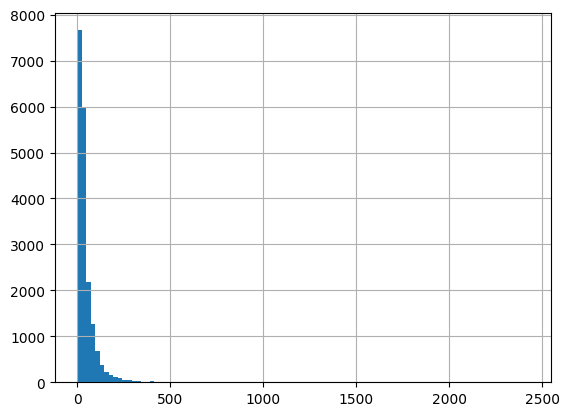

In [33]:
vacant_correct["vacant_flats_count"].hist(bins=100)

<AxesSubplot: >

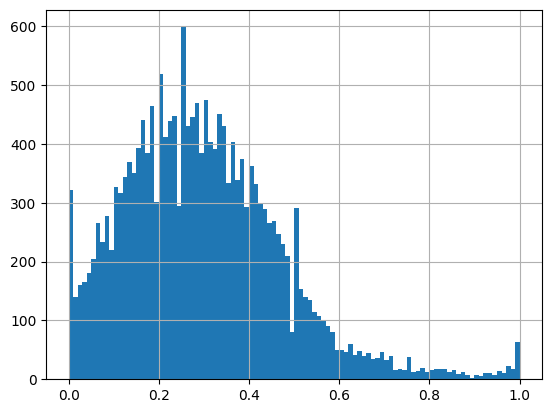

In [34]:
vacant_correct["vacant_flats_share"].hist(bins=100)

Сохраним результат.

In [35]:
vacant_correct.to_csv("data/vacant_v2.csv", index=False)

In [36]:
vacant_by_mo.to_csv("data/vacant_by_mo.csv", index=False)

# Итоги

## Плюсы

1. Оно работает.
2. Оно опирается исключительно на общедоступные данные.
3. Оно считается на уровне домов: с одной стороны, достаточно детально, а с другой стороны, не «сливает» персональные данные жителей (и вообще их не использует).
4. Оно масштабируется на всю страну, если повозиться со сбором сведений.
5. Оно масштабируется на другой временной период, если взять данные за прошлое время.

## Минусы

1. Методика заведомо неточная и порождает очевидные ошибки.
2. Большое количество домов исключается из расчётов из-за нехватки данных или других проблем.

## Возможности улучшения

1. Более точные и полные данные.
2. Ground-truth валидация результатов.